#Importing the libraries , VGG19 model and Keras Dataset API

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.models import Model
from matplotlib.pyplot import imshow

from google.colab import files
from io import BytesIO
from PIL import Image

#Load the model

In [55]:
model = VGG19(include_top=False,weights='imagenet')
model.trainable = False

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#Upload content and style image from local storage

In [56]:
#uploading content image
uploaded_content = files.upload()
content_image = Image.open(BytesIO(uploaded_content['louvre.jpg']))

#uploading style image
uploaded_style = files.upload()
style_image = Image.open(BytesIO(uploaded_style['art2.jpg']))

Saving louvre.jpg to louvre (1).jpg


Saving art2.jpg to art2 (1).jpg


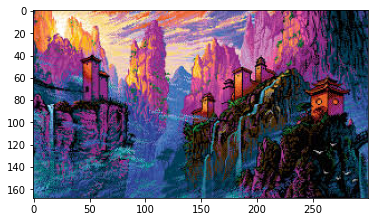

In [57]:
imshow(style_image)

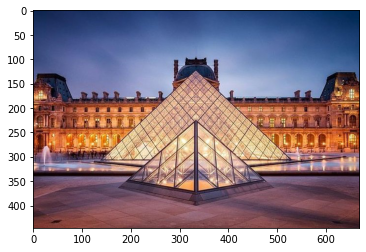

In [58]:
imshow(content_image)

#Preprocessing the Image

In [59]:
def preprocess_image(imag):
    # convert image to array
    img = img_to_array(imag)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

#Deprocessing the image

In [62]:
def deprocess(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]
 
    img = np.clip(img, 0, 255).astype('uint8')
    return img

#Display the generated image

In [63]:
def display_image(image):
    # remove one dimension as the image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
 
    img = deprocess(img)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

#Defining the content model

In [64]:
#content_layer = 'block5_conv2'
content_layer = 'block4_conv2'
content_model = Model(inputs=model.input,outputs=model.get_layer(content_layer).output)
content_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

#Defining Style Model

In [65]:
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,outputs=model.get_layer(layer).output) for layer in style_layers]

#Content Cost

In [66]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    J = tf.reduce_mean(tf.square(a_C - a_G))
    return J

#Gram Matrix

In [67]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    J = tf.matmul(a, a, transpose_a=True)
    return J / tf.cast(n, tf.float32)

#Setting the weights for style layers

In [68]:
weight_of_layer = 1. / len(style_models)

#or manually setting up
#STYLE_LAYERS = [
#('block1_conv1', 0.3),
#('block2_conv1', 0.25),      
#('block3_conv1', 0.2),
#('block4_conv1', 0.2),
#('block5_conv1', 0.2)]

#Style Cost

In [69]:
def style_cost(style, generated):
    J_style = 0
 
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)                            
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight_of_layer
 
    return J_style

In [70]:
generated_images = []

In [71]:
def noise_generation(A):
    noise_ratio = 0.6
    IMAGE_HEIGHT = A.shape[1]
    IMAGE_WIDTH = A.shape[2]
    COLOR_CHANNELS = 3
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + A * (1 - noise_ratio)
    
    return input_image


#Training the model

In [72]:
def model_training(content_image, style_image, iterations=200, a=10, b=1000):
    content = preprocess_image(content_image)
    style = preprocess_image(style_image)
    #generated = tf.Variable(content, dtype=tf.float32)
    #generated_image = noise_generation(content_image)
    generated1 = noise_generation(content)
    generated = tf.Variable(generated1, dtype=tf.float32)
 
    opt = tf.keras.optimizers.Adam(learning_rate=7)
 
    best_cost = float('inf')
    best_image = None
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
 
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        #opt.minimize(J_total,var_list=[J_content,J_style])
 
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
 
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())
 
    return best_image

#Final Image generated

In [73]:
final_img = model_training(content_image, style_image)

Iteration :0
Total Loss 1.491588e+14.
Iteration :1
Total Loss 1.145546e+14.
Iteration :2
Total Loss 7.300673e+13.
Iteration :3
Total Loss 4.140138e+13.
Iteration :4
Total Loss 2.597263e+13.
Iteration :5
Total Loss 2.114136e+13.
Iteration :6
Total Loss 1.999107e+13.
Iteration :7
Total Loss 1.834280e+13.
Iteration :8
Total Loss 1.507488e+13.
Iteration :9
Total Loss 1.143316e+13.
Iteration :10
Total Loss 9.335950e+12.
Iteration :11
Total Loss 8.254072e+12.
Iteration :12
Total Loss 7.544744e+12.
Iteration :13
Total Loss 6.922677e+12.
Iteration :14
Total Loss 6.204497e+12.
Iteration :15
Total Loss 5.438345e+12.
Iteration :16
Total Loss 4.800568e+12.
Iteration :17
Total Loss 4.399824e+12.
Iteration :18
Total Loss 4.167203e+12.
Iteration :19
Total Loss 3.946702e+12.
Iteration :20
Total Loss 3.663201e+12.
Iteration :21
Total Loss 3.331721e+12.
Iteration :22
Total Loss 3.006566e+12.
Iteration :23
Total Loss 2.760427e+12.
Iteration :24
Total Loss 2.601050e+12.
Iteration :25
Total Loss 2.477749e+

#Displaying image generated in various iterations

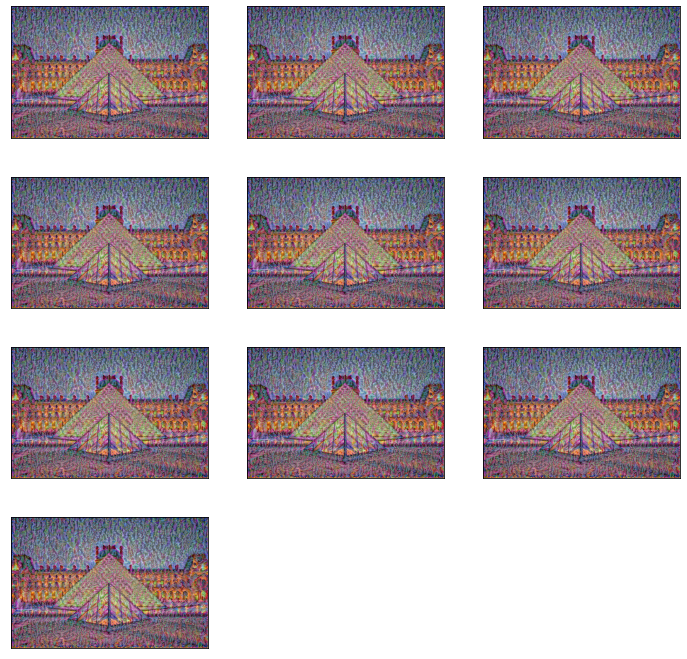

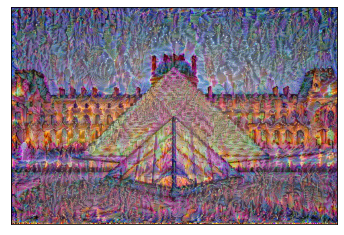

In [74]:

# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))
 
for i in range(10):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[i+39])
plt.show()
 
# plot best result
display_image(final_img)